# Analysis of U.S. Gun Sales

Within the last decade, the topic of gun violence and gun control has become a serious issue with opinions becoming very polar and political on what solution is the safest and most practicle for a modern America. Many people believe that the United States is in an arms race against itself and the need for citizen to carry firearms is obsolete. Others believe it is natural to want to protect yourself and your home with a firearm. 

With the wide spectrum of opinion that has grown in America, we wanted to pose a question near the root of the problem: Can gun sales be predicted by mass shootings?

## Data Sources

We gathered data from a wide variety of sources in our research. The first source we used was from the Gun Violence Archive which provided key data on our primary variable of interest: gun violence. The [GVA](http://www.gunviolencearchive.org) was founded in 2013 to provide public data on mass shootings. This data provided a baseline for the timeseries of our models.

The second source we used was the [National Criminal Background Check System](https://www.fbi.gov/services/cjis/nics). From this source we extrapelated the total number of gun sales, which is our dependent variable.

Finally, we used population data from the [U.S. Census Bureau](https://www.census.gov/data/tables/2017/demo/popest/state-total.html#par_textimage) to normalize different features on the state level. Unfortunately, this data is yearly rather than monthly so it is not as accurate. However, we felt that this still accurately represented the population so we just used the yearly counts.

## Data Cleaning and Feature Creation

The data preperation was a three part process. The first step in preparing the data was to concatonate all of the mass shooting data by year into one dataframe. This was convienent since all of our data came from the same source. The second step focused on gun sales in the US. This data was also already packaged nicely, the only work needed was to split up the month and year to force them into integers for merging and totaling the counts for the US as a whole. Then, state population was added to the sales dataframe to later create features relative to population.

The final step in creating the dataframe was to merge the shooting data with the gun sale data. Once that was complete, we were ready for feature selection. The first feature we decided to create was the number of people affected, which is simply number of people injured and number of people killed. Then to quantify large incidents we created a boolean that measured if over 10 people were affected in the incident. The next two features we added the average number of of deaths and injuries based on the number of incidents in each month. Finally, we normalized the values based on population of the state in which they occured.

## Exploration of Data

Our final dataframe was a 3120 rows by 30 columns dataframe which contained gun sale, population, and mass shooting information for each state monthly. To better understand this large dataset we looked for visual relationships between our potential predictor variables and gun sales. The following is a set of insights we gained from our research.

### Seasonality within both gun sales and mass shootings:

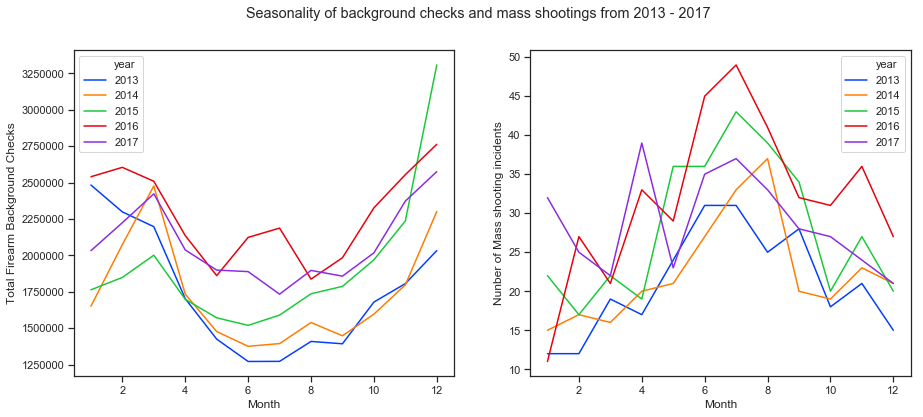

In [7]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # for visualiation

# creating Dataframes
gunsale_population_by_shooting = pd.read_csv('./data/shootings_and_sales_per_pop.csv')
united_states_totals = gunsale_population_by_shooting[gunsale_population_by_shooting.state ==  "United States"]

# First graphs size, rows, title and color set.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
fig.suptitle('Seasonality of background checks and mass shootings from 2013 - 2017')
palette = sns.color_palette("bright", 5)

# Plotting each
sns.lineplot(x="month", y="totals",
   hue="year", palette = palette,
   data=united_states_totals, ax=ax1)
ax1.set(xlabel='Month', ylabel='Total Firearm Background Checks')

sns.lineplot(x="month", y="incidents",
            hue="year", palette = palette,
            data=united_states_totals, ax=ax2)
ax2.set(xlabel='Month', ylabel='Nunber of Mass shooting incidents')

plt.show()

The seasons of each of these are almost opposite to each other. Gun sales peak towards December while [mass shooting incidents](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4985111/) increase towards the end of the summer. One important characteristic to notice is that specific events can be seen on the background checks graph. For example June of 2016 is an outlier which is when the Orlando Massacre happened. 


### How do state's number of mass shootings and the number of background checks change overtime.


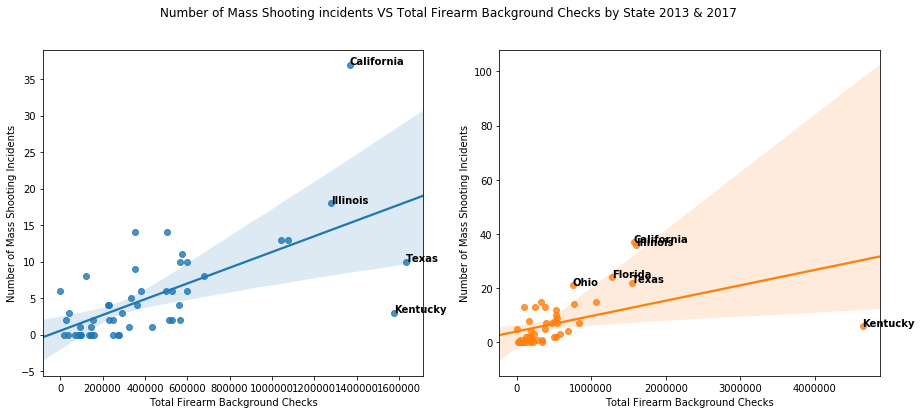

In [2]:
# Remove the country totals
states_only = gunsale_population_by_shooting[gunsale_population_by_shooting.state != "United States"]

# Aggregates for different years.
states_2013_totals = states_only[states_only["year"] == 2013].groupby(["state","year"]).sum()
states_2017_totals = states_only[states_only["year"] == 2017].groupby(["state","year"]).sum()

# First graphs size, rows, title and color set.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
fig.suptitle('Number of Mass Shooting incidents VS Total Firearm Background Checks by State 2013 & 2017')
palette = sns.color_palette("bright", 5)


# Plotting
sns.regplot(states_2013_totals["totals"],
                states_2013_totals["incidents"], ax = ax1)
ax1.set(xlabel='Total Firearm Background Checks', ylabel='Number of Mass Shooting Incidents')

# Adds labels to rows with state name that I preselected.
for line in range(0,states_2013_totals.shape[0]):
    if states_2013_totals.reset_index().state[line] in ["California", "Texas", "Illinois", "Kentucky"]:
        ax1.text(states_2013_totals.totals[line]+0.2, states_2013_totals.incidents[line],
                 states_2013_totals.reset_index().state[line], horizontalalignment='left', size='medium',
                 color='black', weight='semibold')


sns.regplot(states_2017_totals["totals"],
                states_2017_totals["incidents"], ax = ax2)
ax2.set(xlabel='Total Firearm Background Checks', ylabel='Number of Mass Shooting Incidents')

# Adds labels to rows with state name that I preselected.
for line in range(0,states_2017_totals.shape[0]):
    if states_2017_totals.reset_index().state[line] in ["California", "Texas", "Illinois", "Kentucky", "Florida", "Ohio"]:
        ax2.text(states_2017_totals.totals[line]+0.2, states_2017_totals.incidents[line],
                 states_2017_totals.reset_index().state[line], horizontalalignment='left', 
                 size='medium', color='black', weight='semibold')

plt.show()

While it may look like there is some sort of correlation from this regression plot, there are luckily a lot of states which don't have mass shootings which skews this graph. It seems the state itself has a large influence on the number of mass shootings such as Illinois and California. 

### What the background checks totals are made up by.

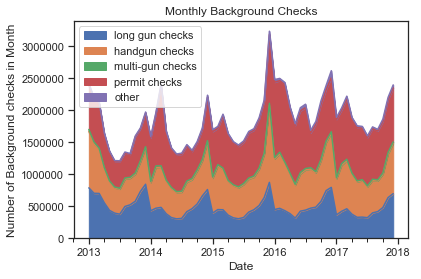

In [10]:
# Used for the time series.
dates = pd.DataFrame({"month": united_states_totals.month,
                      "year": united_states_totals.year,
                      "day": 1
                     })

# Created a seperate data frame for the stacked plot
just_gun_sales = pd.DataFrame({"date": pd.to_datetime(dates),
                              "long gun checks": united_states_totals.long_gun,
                               "handgun checks": united_states_totals.handgun,
                               "multi-gun checks": united_states_totals.multiple,
                               "permit checks": united_states_totals.permit,
                               "other": united_states_totals.other
                              })

stacked_check_plot = just_gun_sales.plot.area(x="date", title="Monthly Background Checks")
stacked_check_plot.set(xlabel="Date", ylabel="Number of Background checks in Month")
stacked_check_plot

Multi-gun firearm background checks are pretty rare in comparison to the other categories which helps our model be more accurate as we are trying to estimate the number of guns sold using the checks. Here you can again see a seasonality of the background checks as well as spikes from certain events like the 2016 Orlando massacre.

### Population vs background checks:

Text(0.5,0.98,'December 2017')

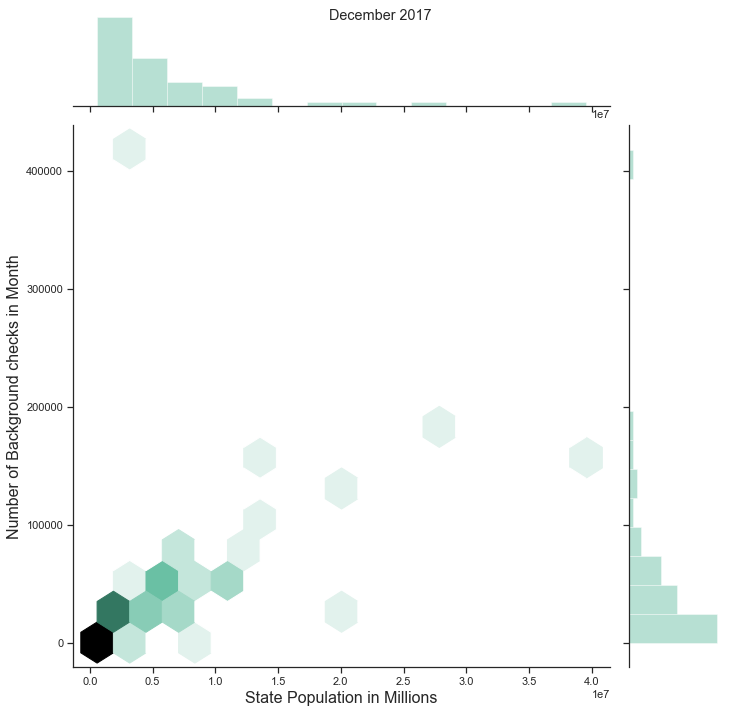

In [16]:
sns.set(style="ticks")
#first_month = states_only[(states_only.year == 2013) & (states_only.month == 1)]
last_month = states_only[(states_only.year == 2017) & (states_only.month == 12)]
pop_totals_graph = sns.jointplot(last_month.population, last_month.totals, kind="hex", height=10, color="#4CB391")
pop_totals_graph.set_axis_labels('State Population in Millions', 'Number of Background checks in Month', fontsize=16).fig.suptitle('December 2017')

## Feature Selection

Include a correlation heatmap somewhere here.

## Models

### _Statistical Model_ 

### _Machine Learning Models_

In [5]:
# Regressions and stuff

### Model of Choice

In [6]:
# Our final choice

## Interpretation and Analysis

We are the best modelers